In [1]:
import pandas as pd
from data_loader import data_load_and_split, data_merge

big_firstMeas_train, big_secondMeas_train, big_firstMeas_test, big_secondMeas_test, train1, train2, test1, test2 = data_load_and_split()

c:\Users\duffi\OneDrive\Documents\2024JobHuntBootCamps\Trees Project\Erdos_Trees\machine_learning\data_loader.py:5: DtypeWarning: Columns (86,168,207,211,215) have mixed types. Specify dtype option on import or set low_memory=False.
  def data_load_and_split(big_data=pd.read_csv('../Data/final_big_data.csv'),
c:\Users\duffi\OneDrive\Documents\2024JobHuntBootCamps\Trees Project\Erdos_Trees\machine_learning\data_loader.py:6: DtypeWarning: Columns (55,59,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trimmed_data= pd.read_csv('../Data/trimmed_data.csv'),


In [2]:
train1.info(verbose = True)
train1.head()

train2.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 9725 entries, 5504 to 7408
Data columns (total 67 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               9725 non-null   int64  
 1   PLOT                     9725 non-null   int64  
 2   LAT                      9725 non-null   float64
 3   LON                      9725 non-null   float64
 4   ELEV                     9725 non-null   float64
 5   COUNTYCD                 9725 non-null   int64  
 6   UNITCD                   9725 non-null   int64  
 7   PLT_CN                   9725 non-null   int64  
 8   CN                       9725 non-null   int64  
 9   PREV_TRE_CN              0 non-null      float64
 10  UNIQUE_PLOT_ID           9725 non-null   object 
 11  INVYR                    9725 non-null   int64  
 12  MEASYEAR                 9725 non-null   int64  
 13  MEASMON                  9725 non-null   int64  
 14  MEASDAY                  9

##### This section is to satisfy my own curiosity about species representation in the dataset:

In [3]:
train1.SPGRPCD.value_counts()

SPGRPCD
10    2657
12    2278
21    2139
11     910
18     625
24     369
19     360
13     103
22      81
44      67
48      49
15      38
47      30
46      18
45       1
Name: count, dtype: int64

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

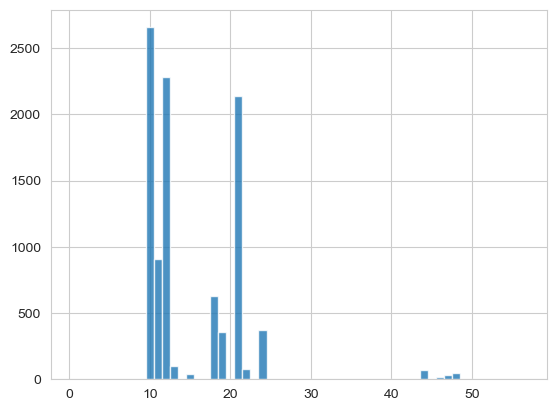

In [5]:
plt.hist(train1["SPGRPCD"], range = [0.5,56.5], bins = 56, alpha = .8)
plt.show()

Codes 1-24 are softwoods, 25-48 are hardwoods, 51-54 are tropical/subtropical, and 55-56 are "urban" (whatever that means). Full details in Appendix E of the FIA user guide. So the vast majority of our sample are softwoods of various types. It might make sense to break those apart further eventually.

#### (Transferred to data_loader)

In [6]:
# combined_train = train1.merge(train2, left_on = "CN", right_on = "PREV_TRE_CN", suffixes = ("_pre_burn", "_post_burn"))
# combined_train.dropna(axis = 1, how = "all", inplace = True)

# # Checking the merge and removing redundant identifiers
# assert((combined_train["CN_pre_burn"] == combined_train["PREV_TRE_CN_post_burn"]).all())
# combined_train.drop("PREV_TRE_CN_post_burn", axis = 1, inplace = True)
# combined_train.rename(columns={"CN_pre_burn": "CN"}, inplace = True)

# if (combined_train["CONDID_pre_burn"] == combined_train["PREVCOND_post_burn"]).all():
#     combined_train.drop("PREVCOND_post_burn", axis = 1, inplace = True)
# else: print("Merge issue! CONDID inconsistent!")

# # Cleaning up redundant columns
# stable_features = ["PLOT", "LAT", "LON", "ELEV", "COUNTYCD", "UNITCD", "TREE", "SUBP", "UNIQUE_PLOT_ID", "SPCD", "SPGRPCD"]
# for col in stable_features:
#     if (combined_train[col + "_pre_burn"] == combined_train[col + "_post_burn"]).all():
#         combined_train.drop(col+"_post_burn", axis = 1, inplace = True)
#         combined_train.rename(columns={col+"_pre_burn": col}, inplace = True)
#     else: 
#         print(f"Merge issue! {col} doesn't match!")


# # Simplifying fire column names
# for num in ["1","2","3"]:
#     for col in ["INCIDENT", "FIREYEAR", "AREA", "PERIM"]:
#         combined_train.rename(columns={col+num+"_post_burn": col+num}, inplace = True)

# print("-"*70)
# combined_train.info(verbose=True, show_counts=True)
# combined_train[combined_train["SPGRPCD_pre_burn"] != combined_train["SPGRPCD_post_burn"]].count()

In [7]:
# import numpy as np

In [ ]:
# # Manipulating burn data to use as features
# for i in ["1","2","3"]:
#     combined_train[f"YRS_SINCE_BURN{i}"] = combined_train["MEASYEAR_post_burn"] - combined_train[f"FIREYEAR{i}"]
# combined_train["YRS_SINCE_BURN"] = combined_train[["YRS_SINCE_BURN1","YRS_SINCE_BURN2","YRS_SINCE_BURN3"]].min(axis = 1)
# combined_train["NUM_BURNS"] = combined_train[["FIREYEAR1","FIREYEAR2","FIREYEAR3"]].notna().sum(axis=1)
# combined_train["BURN_AREA_TOTAL"] = combined_train[["AREA1","AREA2","AREA3"]].sum(axis=1)

# # Manipulating species codes to use as a feature
# combined_train["SOFTWOOD"] = 1*(combined_train["SPGRPCD_pre_burn"].between(0,24, inclusive = "both") & combined_train["SPGRPCD_post_burn"].between(0,24, inclusive = "both"))
# combined_train["HARDWOOD"] = 1*(combined_train["SPGRPCD_pre_burn"].between(25,48, inclusive = "both") & combined_train["SPGRPCD_post_burn"].between(25,48, inclusive = "both"))

# # combined_train["SOFTWOOD"].value_counts()
# # combined_train["HARDWOOD"].value_counts()
# # These showed that all trees in the sample were either soft or hardwoods (i.e. we didn't have any "tropical" or "urban",
# # and the species code inconsistencies seen above didn't mismatch outside of their tree soft/hardwood tree family)

# combined_train["ALIVE_pre_burn"] = 1*(combined_train["STATUSCD_pre_burn"] == 1)
# combined_train["ALIVE_post_burn"] = 1*(combined_train["STATUSCD_post_burn"] == 1)

# print(combined_train["STATUSCD_post_burn"].value_counts(),
#       "\n0 = couldn't resample, 1 = alive, 2 = dead, 3 = removed by humans")

# # Removing trees that were dead before, or removed or nonsampled after
# combined_train = combined_train[~((combined_train['STATUSCD_pre_burn'] ==2) | (combined_train['STATUSCD_post_burn']==3) | (combined_train['STATUSCD_post_burn']==0))]

# print("-"*80, "\n", combined_train["STATUSCD_post_burn"].value_counts(),
#       "\n0 = couldn't resample, 1 = alive, 2 = dead, 3 = removed by humans")

NameError: name 'combined_train' is not defined

In [ ]:
# indicator_features = ["ALIVE_pre_burn", "CULL_pre_burn", "DIA_pre_burn", "HT_pre_burn", "DRYBIO_AG_pre_burn", "ELEV", "SOFTWOOD", "YRS_SINCE_BURN", "NUM_BURNS", "BURN_AREA_TOTAL"] #unfinished
# meta_features = ["CN"]
# outcome_features = ["ALIVE_post_burn", "CULL_post_burn"] 
# mini_train = combined_train[meta_features + indicator_features + outcome_features]

# mini_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 7443 entries, 0 to 9724
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CN                  7443 non-null   int64  
 1   ALIVE_pre_burn      7443 non-null   int32  
 2   CULL_pre_burn       6751 non-null   float64
 3   DIA_pre_burn        7443 non-null   float64
 4   HT_pre_burn         7443 non-null   float64
 5   DRYBIO_AG_pre_burn  7443 non-null   float64
 6   ELEV                7443 non-null   float64
 7   SOFTWOOD            7443 non-null   int32  
 8   YRS_SINCE_BURN      7443 non-null   float64
 9   NUM_BURNS           7443 non-null   int64  
 10  BURN_AREA_TOTAL     7443 non-null   float64
 11  CONDID_post_burn    7443 non-null   int64  
 12  CULL_post_burn      5764 non-null   float64
dtypes: float64(8), int32(2), int64(3)
memory usage: 755.9 KB


## On to the data science!

#### K Nearest Neighbors

In [ ]:
train = data_merge(train1, train2,)
test = data_merge(test1, test2)

train.info(verbose=True, show_counts=True)

SPCD inconsistent; column will not be merged.
SPGRPCD inconsistent; column will not be merged.
SPCD inconsistent; column will not be merged.
SPGRPCD inconsistent; column will not be merged.
<class 'pandas.core.frame.DataFrame'>
Index: 7443 entries, 0 to 9724
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CN                  7443 non-null   int64  
 1   ALIVE_pre_burn      7443 non-null   int64  
 2   CULL_pre_burn       6751 non-null   float64
 3   DIA_pre_burn        7443 non-null   float64
 4   HT_pre_burn         7443 non-null   float64
 5   DRYBIO_AG_pre_burn  7443 non-null   float64
 6   ELEV                7443 non-null   float64
 7   SOFTWOOD            7443 non-null   int64  
 8   YRS_SINCE_BURN      7443 non-null   float64
 9   NUM_BURNS           7443 non-null   int64  
 10  BURN_AREA_TOTAL     7443 non-null   float64
 11  ALIVE_post_burn     7443 non-null   int64  
 12  CULL_post_burn   

In [57]:
from sklearn.model_selection import StratifiedKFold, KFold #, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor

from sklearn.metrics import confusion_matrix, accuracy_score, root_mean_squared_error

In [ ]:
# Removing rows which have no CULL data to use this as a feature
train_no_nan = train.dropna(axis = 0, subset = ["CULL_pre_burn"])

splits = 5
kfold = StratifiedKFold(splits, random_state=216, shuffle=True)
# indicator_features = ["ALIVE_pre_burn", "CULL_pre_burn", "DIA_pre_burn", "HT_pre_burn", "DRYBIO_AG_pre_burn",
#                       "ELEV", "SOFTWOOD", "YRS_SINCE_BURN", "NUM_BURNS", "BURN_AREA_TOTAL"]
indicator_features = ["ELEV", "SOFTWOOD", "BURN_AREA_TOTAL"]


for k in range(2,20):
    classifier_pipe = Pipeline([("Scaler", StandardScaler()), 
                                ("KNN Classifier", KNeighborsClassifier(n_neighbors=k))])
    
    acc_list = []
    for i, (train_index, test_index) in enumerate(kfold.split(train_no_nan[indicator_features],train_no_nan['ALIVE_post_burn'])):
        t_train = train_no_nan.iloc[train_index]
        t_val = train_no_nan.iloc[test_index]

        classifier_pipe.fit(t_train[indicator_features], t_train["ALIVE_post_burn"])
        pred = classifier_pipe.predict(t_val[indicator_features])
        acc_list.append(accuracy_score(t_val["ALIVE_post_burn"], pred))
    
    print(f"{k} Neighbors accuracy scores: {acc_list} \n Mean accuracy for {k} Neighbors: {sum(acc_list)/len(acc_list)} \n")

2 Neighbors accuracy scores: [0.7801628423390081, 0.7888888888888889, 0.7770370370370371, 0.822962962962963, 0.8066666666666666] 
 Mean accuracy for 2 Neighbors: 0.7951436795789127 

3 Neighbors accuracy scores: [0.8038490007401925, 0.7896296296296297, 0.7896296296296297, 0.797037037037037, 0.8155555555555556] 
 Mean accuracy for 3 Neighbors: 0.7991401705184089 

4 Neighbors accuracy scores: [0.7971872686898593, 0.7948148148148149, 0.8037037037037037, 0.8066666666666666, 0.8288888888888889] 
 Mean accuracy for 4 Neighbors: 0.8062522685527866 

5 Neighbors accuracy scores: [0.8008882309400445, 0.802962962962963, 0.7933333333333333, 0.8037037037037037, 0.8340740740740741] 
 Mean accuracy for 5 Neighbors: 0.8069924610028238 

6 Neighbors accuracy scores: [0.7971872686898593, 0.7977777777777778, 0.8051851851851852, 0.8192592592592592, 0.8362962962962963] 
 Mean accuracy for 6 Neighbors: 0.8111411574416756 

7 Neighbors accuracy scores: [0.7964470762398224, 0.78, 0.7903703703703704, 0.80148

Noteworthy accuracies: 
- 78.9% with all indicator_features and 4 neighbors
- 81.0% with ["CULL_pre_burn", "ELEV", "SOFTWOOD", "BURN_AREA_TOTAL"] and 8 neighbors
    - far worse with NUM_BURNS instead of BURN_AREA_TOTAL (low 70s)
- 81.5% with ["ELEV", "SOFTWOOD", "BURN_AREA_TOTAL"] and 8 neighbors
    - Adding YRS_SINCE_BURN helps by another % point, HOWEVER this is most likely due to data leakage;
    trees with a higher delay in measuring were probably more likely to have been removed, or impossible
    to locate when it was time to resample.



In [ ]:
# Fitting the best model to the entire test data set:
classifier_pipe = Pipeline([("Scaler", StandardScaler()), 
                            ("KNN Classifier", KNeighborsClassifier(n_neighbors=8))])
best_classifier = classifier_pipe.fit(train_no_nan[indicator_features], train_no_nan["ALIVE_post_burn"])

# Run this on test set once we're done with modeling other features

#### Now let's try to predict the extent of damage.

CULL is defined in the FIA database user guide as "the percent of the cubic-foot volume in a live or dead tally tree
that is rotten or missing.

In [75]:
# Removing rows which have no CULL data to use this as a feature
train_for_cull = train.dropna(axis = 0, subset = ["CULL_pre_burn", "CULL_post_burn"])

splits = 5
kfold = KFold(splits, random_state=216, shuffle=True)
# indicator_features = ["CULL_pre_burn", "DIA_pre_burn", "HT_pre_burn", "DRYBIO_AG_pre_burn",
#                       "ELEV", "SOFTWOOD", "YRS_SINCE_BURN", "NUM_BURNS", "BURN_AREA_TOTAL"]
indicator_features = ["CULL_pre_burn", "DRYBIO_AG_pre_burn", "ELEV", "SOFTWOOD", "YRS_SINCE_BURN", "BURN_AREA_TOTAL"]


for k in range(2,20):
    regressor_pipe = Pipeline([("Scaler", StandardScaler()), 
                                ("KNN Regressor", KNeighborsRegressor(n_neighbors=k))])
    
    score_list = []
    for i, (train_index, test_index) in enumerate(kfold.split(train_for_cull[indicator_features],train_for_cull["CULL_post_burn"])):
        t_train = train_for_cull.iloc[train_index]
        t_val = train_for_cull.iloc[test_index]

        regressor_pipe.fit(t_train[indicator_features], t_train["CULL_post_burn"])
        score_list.append(regressor_pipe.score(t_val[indicator_features],t_val["CULL_post_burn"]))
    
    print(f"{k} Neighbors scores: {score_list} \n Average score for {k} Neighbors: {sum(score_list)/len(score_list)} \n")

2 Neighbors scores: [-0.07088436488676653, -0.03321278000147476, -0.24458748974467648, -0.4825613727167164, -0.06990846090123459] 
 Average score for 2 Neighbors: -0.18023089365017375 

3 Neighbors scores: [-0.015149857704784608, -0.10981459752277534, -0.20195116940888913, -0.3182416494408127, -0.06487536344660039] 
 Average score for 3 Neighbors: -0.14200652750477244 

4 Neighbors scores: [0.004438737315258345, 0.015861552430050163, -0.14048850235388444, -0.33127220760280873, 0.11740778649537764] 
 Average score for 4 Neighbors: -0.0668105267432014 

5 Neighbors scores: [0.003278039185080628, 0.09490878944576364, -0.11468405643872903, -0.1947899435986875, 0.0986185356764131] 
 Average score for 5 Neighbors: -0.022533727146031836 

6 Neighbors scores: [0.02212216940282008, 0.13895653247086814, -0.11620092083625666, -0.15317237862092092, 0.13518282531630632] 
 Average score for 6 Neighbors: 0.005377645546563392 

7 Neighbors scores: [0.03058080799068541, 0.13626805768723527, -0.08697235

From sklearn's documentation: "The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0."

Noteworthy scores:
- Almost all scores I calculated were under 0.1. This indicates KNN is not a very effective method of predicting CULL.
- .083 using all features, 17 neighbors
- .082 using ["CULL_pre_burn", "ELEV", "SOFTWOOD", "YRS_SINCE_BURN", "BURN_AREA_TOTAL"], 17 neighbors
    - adding in DIA or HT made it worse
- .101 using ["CULL_pre_burn", "DRYBIO_AG_pre_burn", "ELEV", "SOFTWOOD", "YRS_SINCE_BURN", "BURN_AREA_TOTAL"] and 18 neighbors

At least it's doing better than the mean regressor since it's consistently over 0. This may be a difficult task because so many entries in the CULL field are 0, even after burn. See below:

In [79]:
train_for_cull["CULL_post_burn"].value_counts(normalize = True).sort_index()

CULL_post_burn
0.0     0.871755
1.0     0.047221
2.0     0.013765
3.0     0.005576
4.0     0.001742
5.0     0.022129
6.0     0.001220
7.0     0.001220
8.0     0.001568
9.0     0.000174
10.0    0.009061
12.0    0.000523
15.0    0.006447
16.0    0.000174
18.0    0.000523
19.0    0.000174
20.0    0.004356
22.0    0.000174
25.0    0.002788
30.0    0.002614
35.0    0.000871
40.0    0.000871
45.0    0.000348
50.0    0.000697
55.0    0.000348
60.0    0.000523
65.0    0.000174
80.0    0.000523
90.0    0.000697
95.0    0.000523
99.0    0.001220
Name: proportion, dtype: float64

Human bias may be playing a part; there's a pronounced tendency towards values that are multiples of 5. The database documentation doesn't have much detail about *how* field crews estimate it, either.